# Homography Estimation and Simple Panorama Construction

This notebook demonstrates the core steps of building a simple panorama from a pair of overlapping images:

1. Load a sequence of images from a dataset folder.
2. Detect local features (ORB and SIFT) and visualize their keypoints.
3. Compare ORB vs SIFT keypoint distributions.
4. Select SIFT features, build a lightweight per-image data structure (keypoints + descriptors).
5. Perform descriptor matching with FLANN + Lowe's ratio test.
6. Visualize raw matches and RANSAC inliers.
7. Estimate the homography between two views using RANSAC.
8. Warp one image into the coordinate frame of the other and compose a naive panorama.

Notes:
- Only minimal blending is performed (simple overwrite). More advanced blending (feathering, multi-band) can be added later.
- The matching currently uses only the first two images (indices 0 and 1). You can iterate across the sequence to chain homographies for a full panorama.
- All code and comments are kept in English for clarity and reproducibility.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Configure matplotlib to display larger, more readable plots
plt.rcParams['figure.figsize'] = [15, 15]

In [ ]:
# Path to the folder containing the images
image_folder = '../data/tower_scene'
# image_folder = '../data/store_scene/'

# Lists to store the loaded images and their names
images = []
image_names = []

# Iterate over all files in the specified folder
print(f"Searching for images in: '{os.path.abspath(image_folder)}'")

for filename in sorted(os.listdir(image_folder)):
    # Check if the file is an image
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Build the full path to the image
        img_path = os.path.join(image_folder, filename)
        
        # Load the image using OpenCV
        img = cv2.imread(img_path)
        
        # Verify that the image was loaded correctly
        if img is not None:
            images.append(img)
            image_names.append(filename)
        else:
            print(f"Could not load image: {filename}")

print(f"Total images loaded: {len(images)}")

Searching for images in: '/Users/mengo/Documents/Doutorado/2025s2/MO446/T1/data/panorama_dataset/tower_scene'
Total images loaded: 2


Image: 'image001.png' - Keypoints detected: 1973


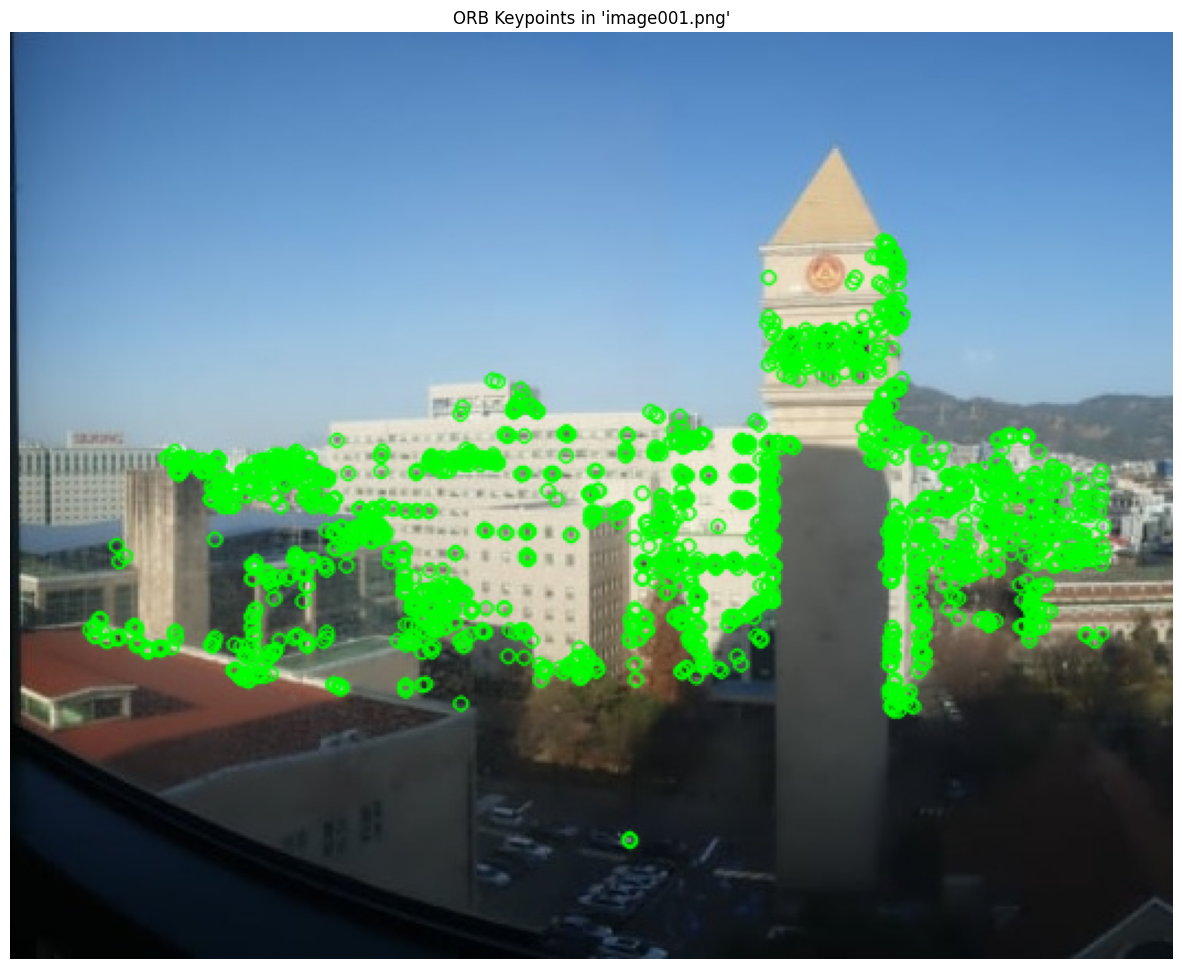

Image: 'image002.png' - Keypoints detected: 1977


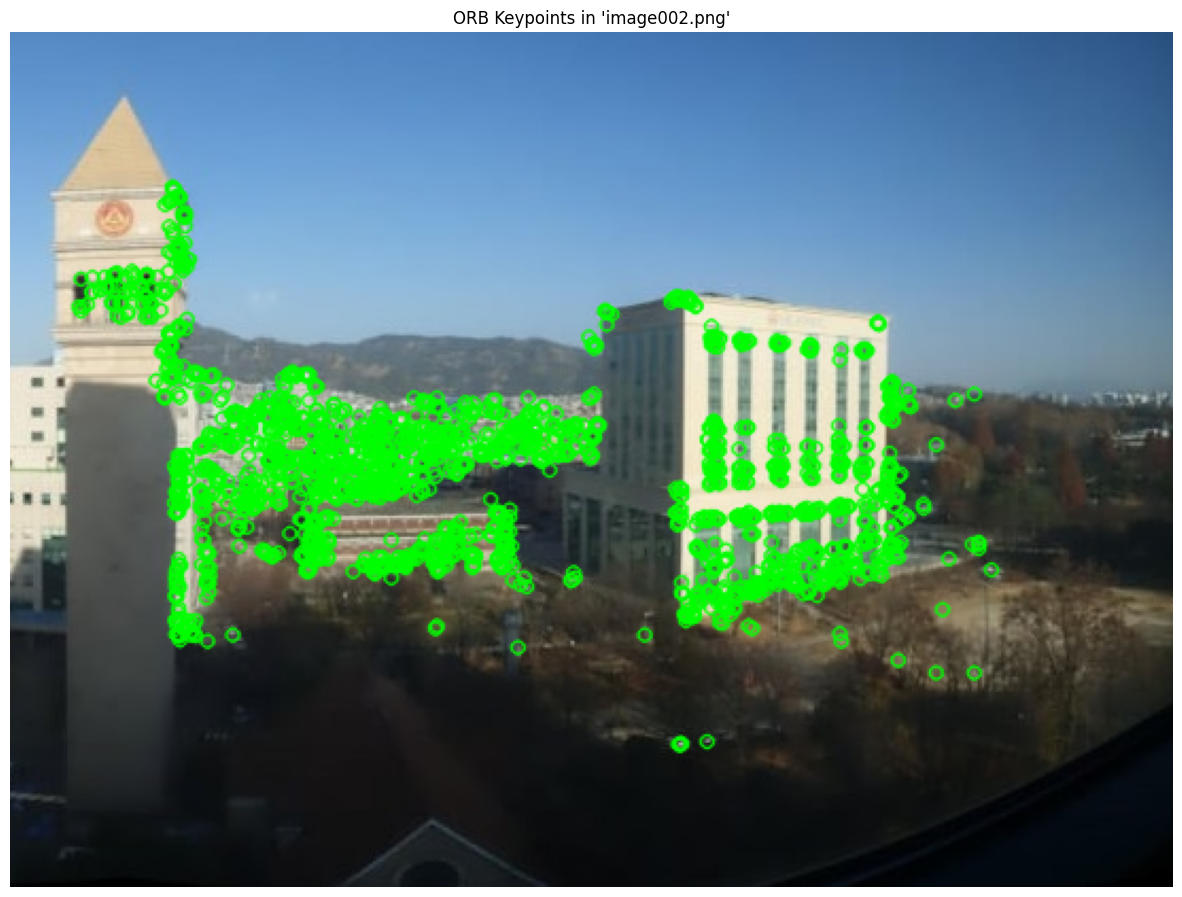

In [3]:
# 1. Initialize the ORB detector
# nfeatures sets the maximum number of keypoints to detect
orb = cv2.ORB_create(nfeatures=2000)

# Iterate over each loaded image
for i, img in enumerate(images):
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2. Detect keypoints and compute their descriptors
    keypoints, descriptors = orb.detectAndCompute(gray_img, None)
    
    # 3. Draw keypoints on the original (color) image
    img_with_keypoints = cv2.drawKeypoints(
        img, 
        keypoints, 
        None, # output image
        color=(0, 255, 0), # draw keypoints in green
        flags=0
    )
    
    print(f"Image: '{image_names[i]}' - Keypoints detected: {len(keypoints)}")
    
    # 4. Display the image using matplotlib
    # Convert from BGR (OpenCV) to RGB (Matplotlib)
    plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(f"ORB Keypoints in '{image_names[i]}'")
    plt.axis('off') # Remove x and y axes
    plt.show()

Image: 'image001.png' - Keypoints detected: 1214


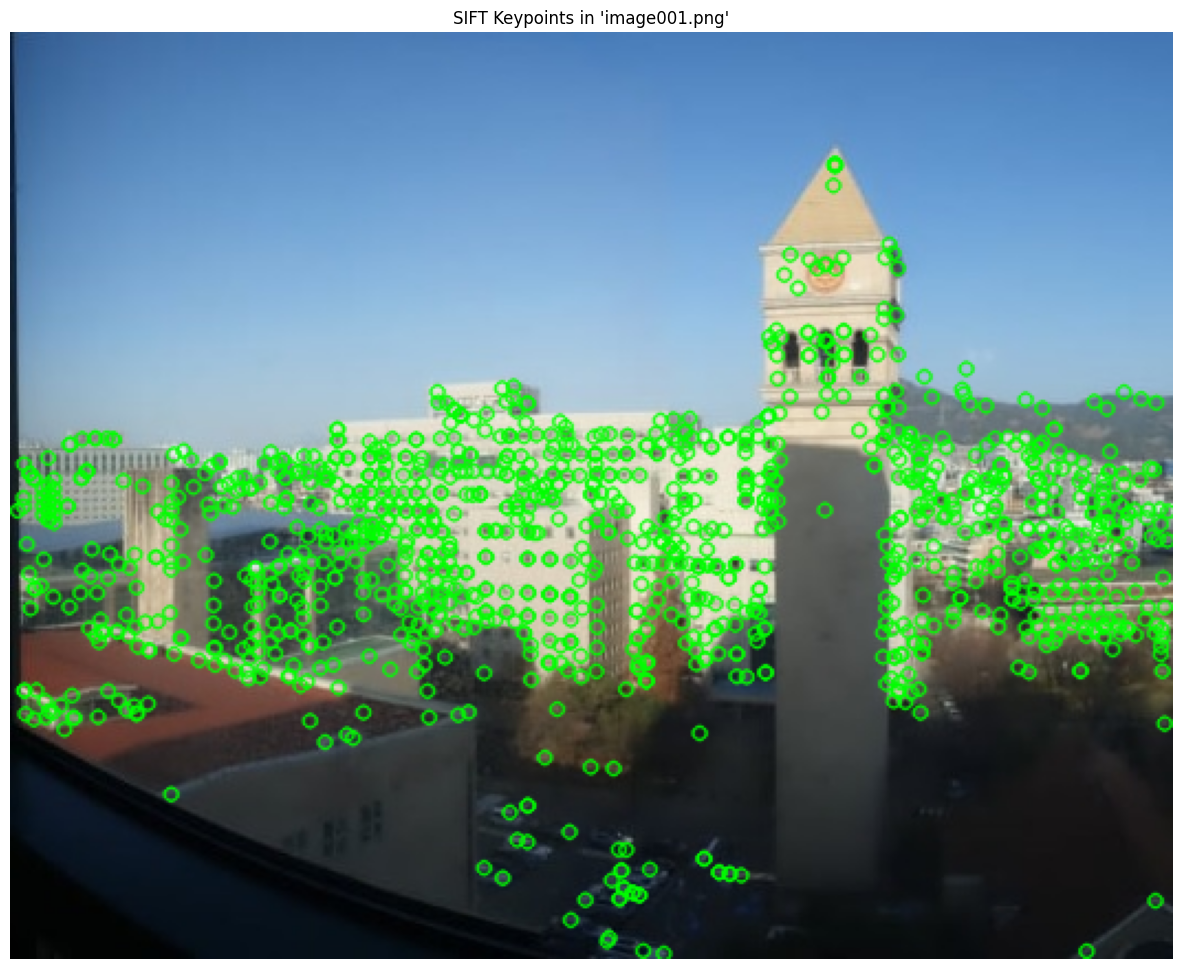

Image: 'image002.png' - Keypoints detected: 1071


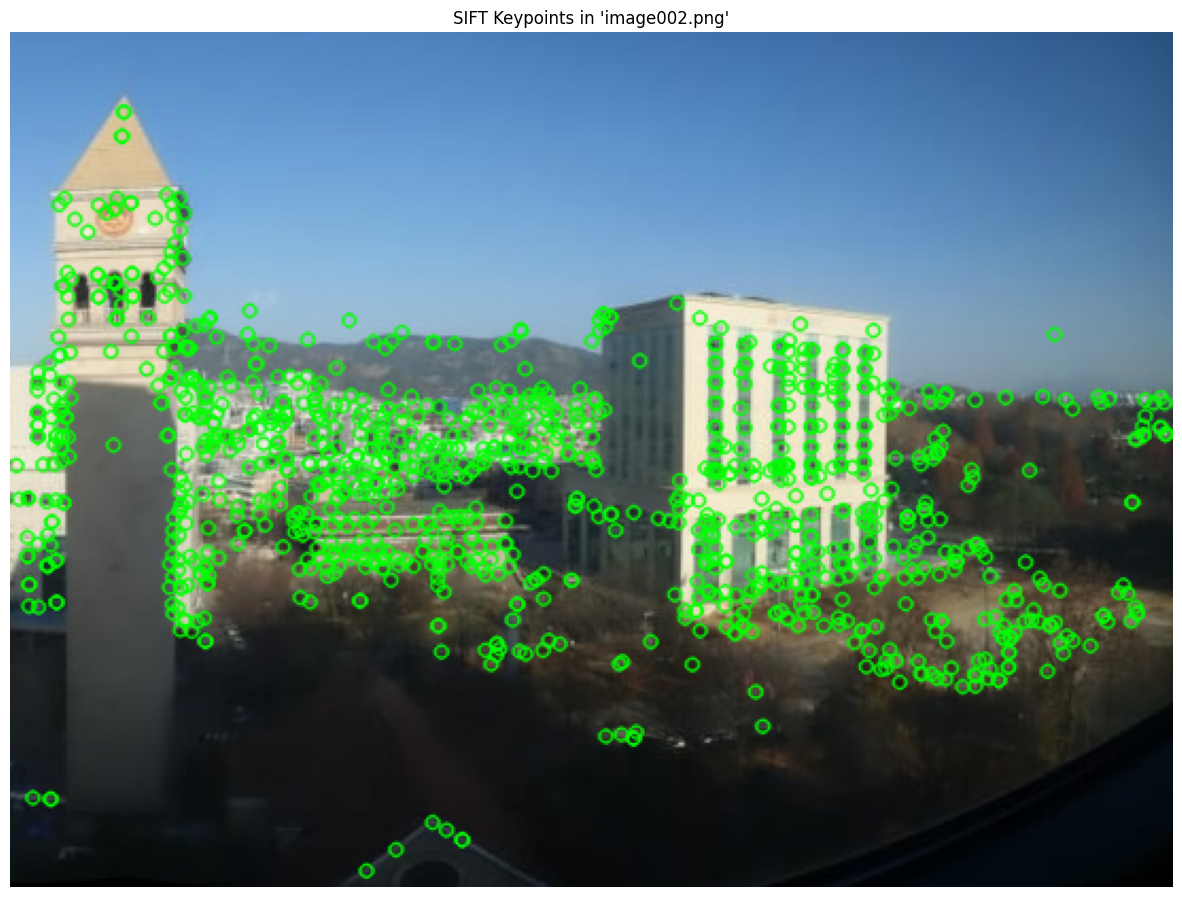

In [4]:
# 1. Initialize the SIFT detector
# nfeatures sets the maximum number of keypoints to detect
sift = cv2.SIFT_create(nfeatures=2000)

# Iterate over each loaded image
for i, img in enumerate(images):
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2. Detect keypoints and compute their descriptors
    keypoints, descriptors = sift.detectAndCompute(gray_img, None)
    
    # 3. Draw keypoints on the original (color) image
    img_with_keypoints = cv2.drawKeypoints(
        img, 
        keypoints, 
        None, # output image
        color=(0, 255, 0), # draw keypoints in green
        flags=0
    )
    
    print(f"Image: '{image_names[i]}' - Keypoints detected: {len(keypoints)}")
    
    # 4. Display the image using matplotlib
    # Convert from BGR (OpenCV) to RGB (Matplotlib)
    plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(f"SIFT Keypoints in '{image_names[i]}'")
    plt.axis('off') # Remove x and y axes
    plt.show()

Image: 'image001.png' - ORB: 1973 | SIFT: 1214


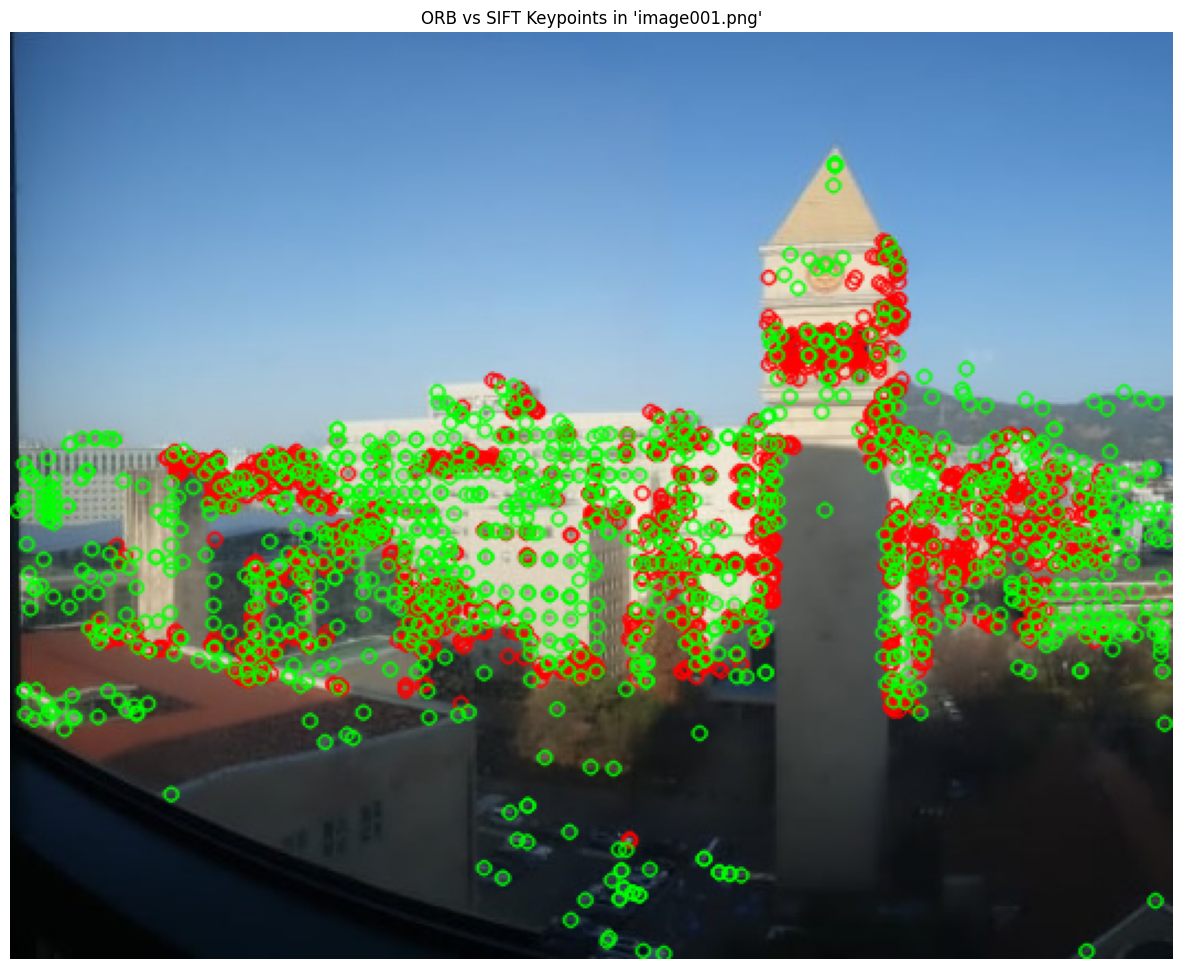

Image: 'image002.png' - ORB: 1977 | SIFT: 1071


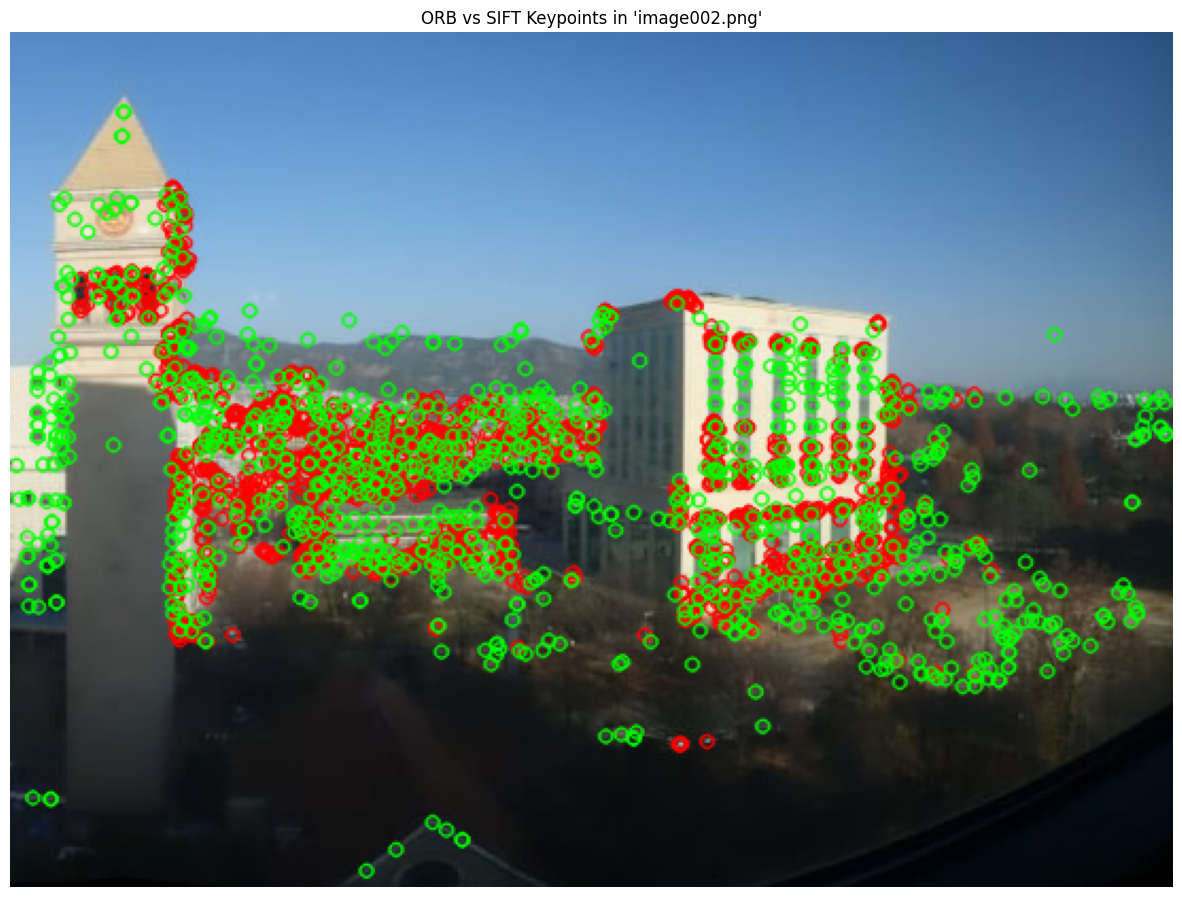

In [5]:
for i, img in enumerate(images):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    orb_keypoints, orb_descriptors = orb.detectAndCompute(gray_img, None)
    sift_keypoints, sift_descriptors = sift.detectAndCompute(gray_img, None)

    img_with_orb_keypoints = cv2.drawKeypoints(
        img, 
        orb_keypoints, 
        None,
        color=(0, 0, 255), # ORB keypoints in red
        flags=0,
    )

    img_with_both_keypoints = cv2.drawKeypoints(
        img_with_orb_keypoints, 
        sift_keypoints, 
        None,
        color=(0, 255, 0), # SIFT keypoints in green
        flags=0,
    )
    
    print(f"Image: '{image_names[i]}' - ORB: {len(orb_keypoints)} | SIFT: {len(sift_keypoints)}")

    plt.imshow(cv2.cvtColor(img_with_both_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(f"ORB vs SIFT Keypoints in '{image_names[i]}'")
    plt.axis('off')
    plt.show()

In [6]:
# Use SIFT because it's scale-invariant?
# TODO: choose number of features that eases visualization without compromising final result
# TODO: explain how ORB, SIFT, FLANN and Lowe's ratio test filtering work
sift = cv2.SIFT_create(nfeatures=500)

In [7]:
dataset = []
for i, img in enumerate(images):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray_img, None)
    # Store structured data for later processing
    dataset.append({'image': img, 'gray': gray_img, 'kp': keypoints, 'desc': descriptors})

In [8]:
K = 2  # number of nearest neighbors for KNN matching
lowe_threshold = 0.85  # Lowe's ratio test threshold
flann_matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)

In [9]:
from typing import Dict, List

def match_image_pair(d1: Dict, d2: Dict) -> List[cv2.DMatch]:
    """Return filtered feature matches between two images.

    Steps:
    1. Perform KNN matching (k=2) between descriptor sets.
    2. Apply Lowe's ratio test to filter ambiguous matches.

    Parameters
    ----------
    d1 : dict
        Dictionary with keys: 'desc' (np.ndarray of descriptors) for image A.
    d2 : dict
        Dictionary with keys: 'desc' (np.ndarray of descriptors) for image B.

    Returns
    -------
    list[cv2.DMatch]
        List of surviving matches after ratio filtering.
    """
    knn_matches = flann_matcher.knnMatch(d1['desc'], d2['desc'], K)
    filtered: List[cv2.DMatch] = []
    for m, n in knn_matches:
        if m.distance < lowe_threshold * n.distance:
            filtered.append(m)
    return filtered

In [10]:
matches = match_image_pair(dataset[0], dataset[1])

In [11]:
# Allocate image to visualize matches side by side
img_matches = np.zeros((
    max(dataset[0]['image'].shape[0], dataset[1]['image'].shape[0]),
    dataset[0]['image'].shape[1] + dataset[1]['image'].shape[1],
    3,
), dtype=np.uint8)

cv2.drawMatches(dataset[0]['image'], dataset[0]['kp'], dataset[1]['image'], dataset[1]['kp'], matches, img_matches)
img_matches = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

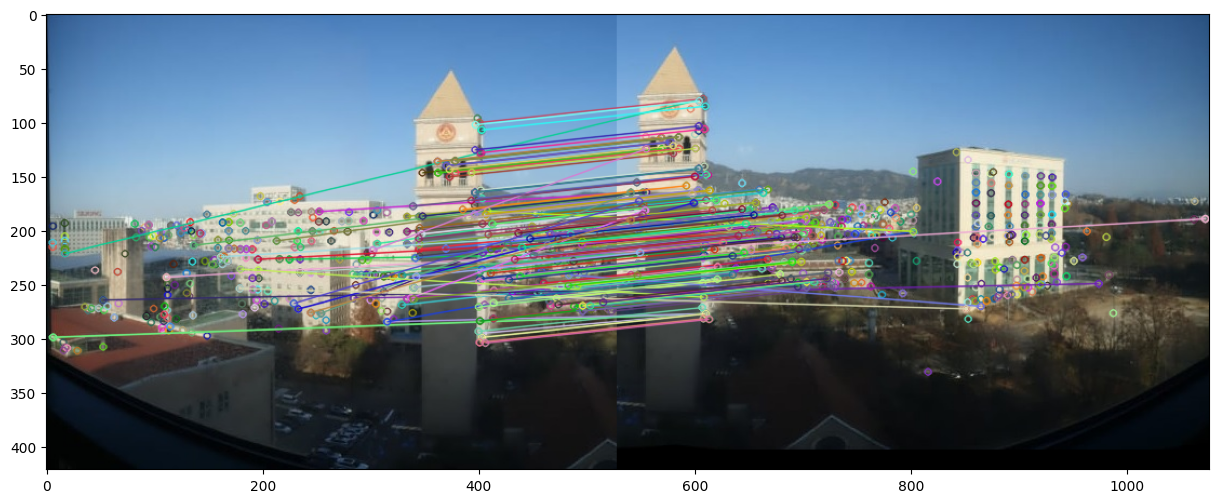

In [12]:
plt.imshow(img_matches)

Estimated Homography (A -> B):
[[ 9.99004657e-01  1.48452139e-04 -3.20675983e+02]
 [-2.25155778e-04  9.99358483e-01 -2.18982779e+01]
 [-1.64869860e-06  1.98466549e-07  1.00000000e+00]]
Inliers: 197 / 230


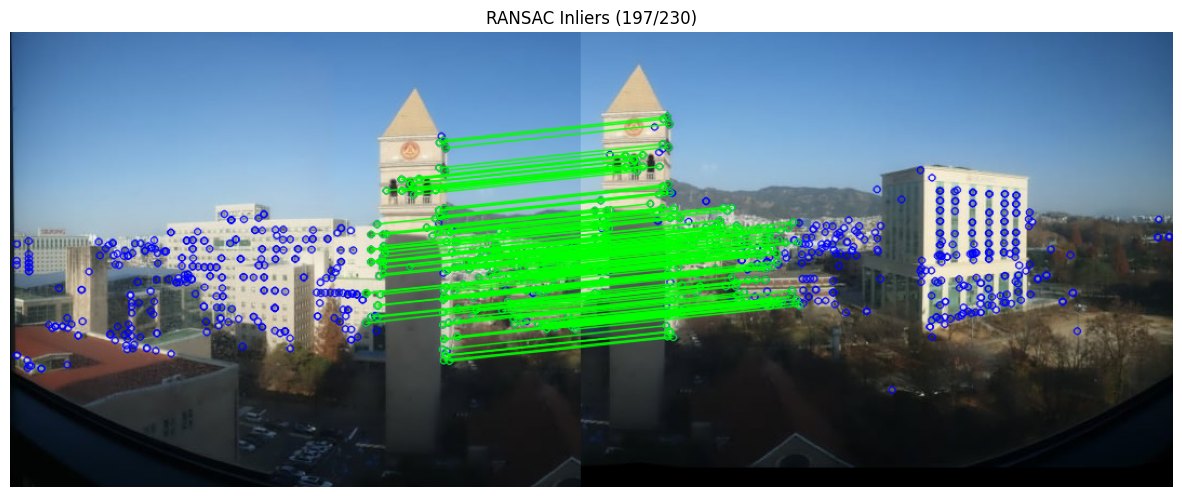

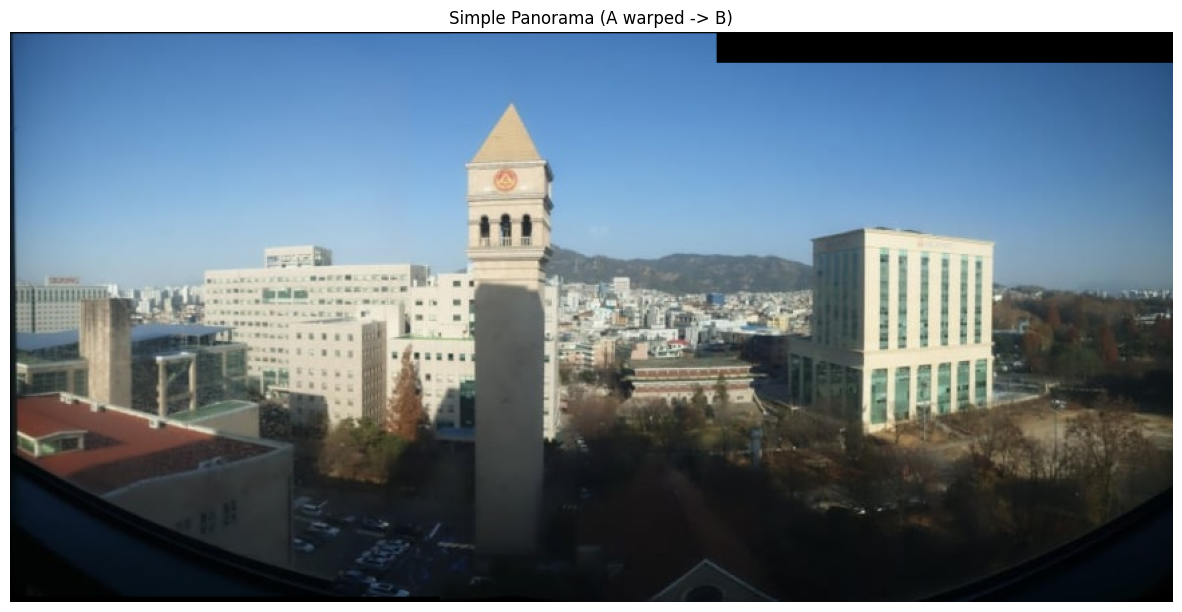

In [13]:
idxA, idxB = 0, 1
imgA = dataset[idxA]['image']
imgB = dataset[idxB]['image']
kpA = dataset[idxA]['kp']
kpB = dataset[idxB]['kp']

# Ensure we have enough matches to estimate H
if len(matches) < 4:
    raise ValueError(f"Insufficient matches to estimate homography: {len(matches)} < 4")

# Build arrays of corresponding 2D points
ptsA = np.float32([kpA[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
ptsB = np.float32([kpB[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Estimate homography using RANSAC
H, inliers_mask = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC, ransacReprojThreshold=3.0, maxIters=2000, confidence=0.995)

if H is None:
    raise RuntimeError("Failed to estimate homography with RANSAC.")

num_inliers = int(inliers_mask.sum())
print(f"Estimated Homography (A -> B):\n{H}")
print(f"Inliers: {num_inliers} / {len(matches)}")

# Visualize only inliers
inlier_matches = [m for m, keep in zip(matches, inliers_mask.ravel().tolist()) if keep]
img_inlier_matches = np.zeros((max(imgA.shape[0], imgB.shape[0]), imgA.shape[1] + imgB.shape[1], 3), dtype=np.uint8)
cv2.drawMatches(imgA, kpA, imgB, kpB, inlier_matches, img_inlier_matches,
                matchColor=(0, 255, 0), singlePointColor=(255, 0, 0))
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(img_inlier_matches, cv2.COLOR_BGR2RGB))
plt.title(f"RANSAC Inliers ({num_inliers}/{len(matches)})")
plt.axis('off')
plt.show()

# Warp A into B's coordinate system for a simple panorama
hB, wB = imgB.shape[:2]
# Estimate canvas size by combining bounding boxes after warp
hA, wA = imgA.shape[:2]

# Corners of A in B coordinates after warp
cornersA = np.float32([[0, 0], [wA, 0], [wA, hA], [0, hA]]).reshape(-1, 1, 2)
warped_cornersA = cv2.perspectiveTransform(cornersA, H)

# Determine mosaic boundaries
all_corners = np.vstack((warped_cornersA, np.float32([[0, 0], [wB, 0], [wB, hB], [0, hB]]).reshape(-1, 1, 2)))
[xmin, ymin] = np.floor(all_corners.min(axis=0).ravel()).astype(int)
[xmax, ymax] = np.ceil(all_corners.max(axis=0).ravel()).astype(int)

# Offset to handle negative coordinates
Tx, Ty = -xmin, -ymin
T = np.array([[1, 0, Tx], [0, 1, Ty], [0, 0, 1]], dtype=np.float64)

# Warp A and paste B
panorama_w = xmax - xmin
panorama_h = ymax - ymin
panorama = cv2.warpPerspective(imgA, T @ H, (panorama_w, panorama_h))

# Simple compositing: place B at its offset position
panorama[Ty:Ty + hB, Tx:Tx + wB] = imgB

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title("Simple Panorama (A warped -> B)")
plt.axis('off')
plt.show()